### Case study 1 - Predicting Interest rate for loans

### Import packages and reading dataset

In [1]:
pip install xgboost

You should consider upgrading via the '/Users/praveen/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import numpy
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import xlrd
import math
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from datetime import datetime
import statsmodels.api as sm
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score


In [332]:
df = pd.read_csv('loans_full_schema.csv', sep=",",engine='python')
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


The Dataset has 55 columns and 10000 records. There are a lot of Na values in annual_income_joint and verification_income_joint which makes sense because not all the loan details are joint type and so they need to be replaced with 0 and null values. 

In addition to that, to build a regression model, we need to do feature engineering and convert all categorical variables by One hot encoding or creating dummies.

In [333]:
df.shape

(10000, 55)

## EDA

<AxesSubplot:title={'center':'State Vs Annual_Income'}, xlabel='state'>

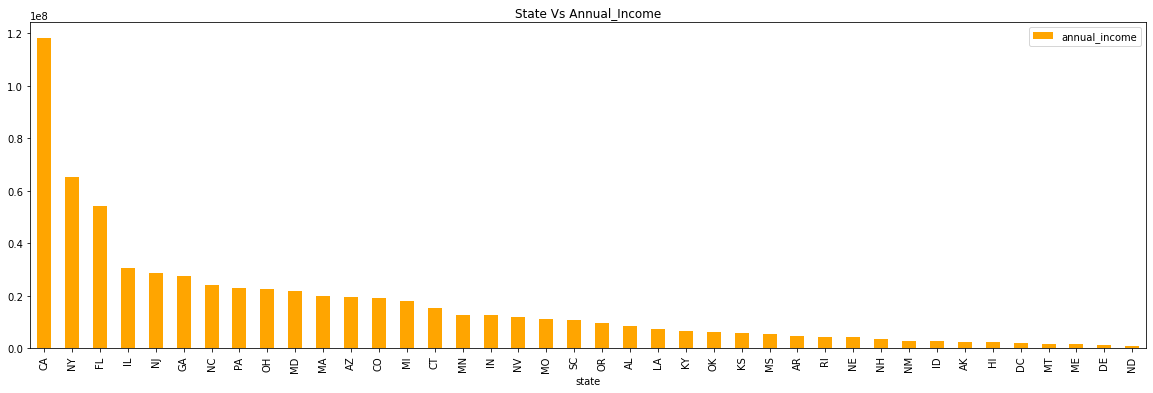

In [341]:
fig2 = plt.figure(figsize=(20,6))

sub2 = fig2.add_subplot(1,1,1)
company_weight_df2 = pd.DataFrame(df.groupby('state').annual_income.sum())
company_weight_df2.columns = ['annual_income']
company_weight_df2[0:40].sort_values(by = 'annual_income',ascending=False).plot(kind="bar", color='orange',title = "State Vs Annual_Income",ax=sub2)

As expected, customers residing in California have the highest income followed by New york and florida.

#### Loan_status,initial listing status, month of issue, disbursement method can be removed as they are irrelevant in predicting the interest rate of a loan sanctioned.

<AxesSubplot:title={'center':'Loan grade Vs Average Interest rate'}, ylabel='grade'>

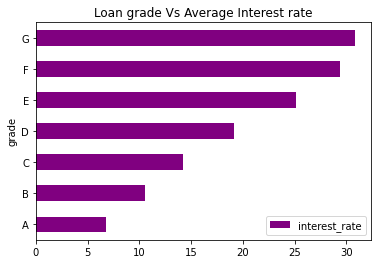

In [352]:
company_weight_df3 = pd.DataFrame(df.groupby('grade').interest_rate.mean())
company_weight_df3[0:10].sort_values(by = 'grade').plot(kind="barh", color='purple', title = "Loan grade Vs Average Interest rate")

#### Loan Grade G has the highest average interest rate followed by F,E as seen from above bar plot.

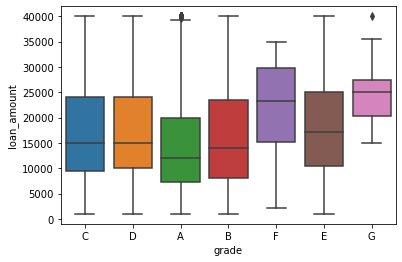

In [356]:
sns.boxplot( y=df["loan_amount"],x=df['grade']);
plt.show()

#### Customers who borrowed loan with grade F have high amount with an average of approximately $23000 sanctioned

([<matplotlib.patches.Wedge at 0x7f8d40fe7fa0>,
 [Text(-0.9808903870058299, 0.49784942370113633, 'Individual'),
  Text(0.9808903636998152, -0.4978494696199289, 'Joint')],
 [Text(-0.535031120184998, 0.27155423110971066, '85.0%'),
  Text(0.5350311074726264, -0.2715542561563248, '14.9%')])

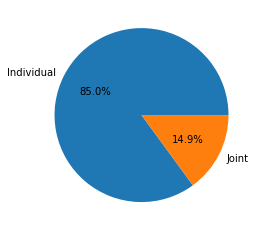

In [357]:
company_weight_df4 = pd.DataFrame(df.groupby('application_type').annual_income.count())
company_weight_df4.columns=['application_type']
labels=['Individual','Joint']
plt.pie(company_weight_df4.application_type,labels=labels,autopct='%.1f%%')

#### From our dataset, it is observed that around 85% of loan types are individual and remaining 15% are joint types.

<AxesSubplot:title={'center':'Homeownership Vs loan_amount'}, xlabel='homeownership'>

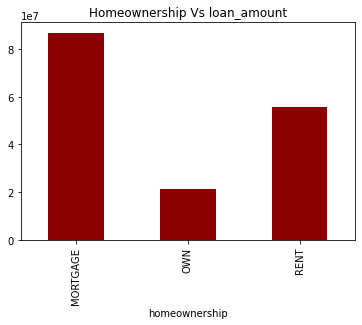

In [373]:
df.groupby('homeownership').loan_amount.sum().plot(kind='bar',color='darkred',title = "Homeownership Vs loan_amount")

#### Customers with mortgage have borrowed higher loan_amount than customers living on rent.

### Data Cleaning and Feature selection

In [227]:
# Dropping categorical variables
df = df.drop(columns = ['emp_title','state','sub_grade','loan_status','loan_purpose','issue_month',
                        'initial_listing_status','disbursement_method'])

In [228]:
df.isna().sum()

emp_length                           817
homeownership                          0
annual_income                          0
verified_income                        0
debt_to_income                        24
annual_income_joint                 8505
verification_income_joint           8545
debt_to_income_joint                8505
delinq_2y                              0
months_since_last_delinq            5658
earliest_credit_line                   0
inquiries_last_12m                     0
total_credit_lines                     0
open_credit_lines                      0
total_credit_limit                     0
total_credit_utilized                  0
num_collections_last_12m               0
num_historical_failed_to_pay           0
months_since_90d_late               7715
current_accounts_delinq                0
total_collection_amount_ever           0
current_installment_accounts           0
accounts_opened_24m                    0
months_since_last_credit_inquiry    1271
num_satisfactory

In [229]:
df = df.fillna(0)
#df['Joint'] = 0
#df.loc[df['application_type']=='joint','Joint'] = 1
#df_joint = df[df.Joint ==1]
#df_single = df[df.Joint ==0]

In [230]:
df["updated_annual_income"]=np.where(pd.notna(df["annual_income_joint"]),df["annual_income_joint"],df["annual_income"])
#df["updated_debt_to_inc"]=np.where(pd.notna(df["debt_to_income_joint"]),df["debt_to_income_joint"],df["debt_to_income"])

In [231]:
df.head()

,emp_length,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,...,term,interest_rate,installment,grade,balance,paid_total,paid_principal,paid_interest,paid_late_fees,updated_annual_income
0,3.0,MORTGAGE,90000.0,Verified,18.01,0.0,0,0.00,0,38.0,...,60,14.07,652.53,C,27015.86,1999.33,984.14,1015.19,0.0,0.0
1,10.0,RENT,40000.0,Not Verified,5.04,0.0,0,0.00,0,0.0,...,36,12.61,167.54,C,4651.37,499.12,348.63,150.49,0.0,0.0
2,3.0,RENT,40000.0,Source Verified,21.15,0.0,0,0.00,0,28.0,...,36,17.09,71.40,D,1824.63,281.80,175.37,106.43,0.0,0.0
3,1.0,RENT,30000.0,Not Verified,10.16,0.0,0,0.00,0,0.0,...,36,6.72,664.19,A,18853.26,3312.89,2746.74,566.15,0.0,0.0
4,10.0,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,0,0.0,...,36,14.07,786.87,C,21430.15,2324.65,1569.85,754.80,0.0,57000.0


In [232]:
df = df.drop(columns=['verification_income_joint','annual_income_joint','debt_to_income_joint','annual_income',
                      'debt_to_income'])

### Dropping irrelevant variables

tax lien is another column which seems to have no correlation with the target variable hence removed.


In [233]:
df = df.drop(columns=['accounts_opened_24m','num_satisfactory_accounts','num_cc_carrying_balance',
                      'account_never_delinq_percent','tax_liens'])

Removing variables containing information about balance and interest fees paid for the loan because they don't contribute to preciting the interest rate when a loan is applied.

In [234]:
df = df.drop(columns=['balance','paid_total','paid_principal','paid_interest','paid_late_fees'])

Remove columns months since 90 days late on payment and months since last delinquency since most of the data are na values and might not really fit in the model in predicting the interest rate.

In [235]:
df = df.drop(columns=['months_since_90d_late','months_since_last_delinq'])

In [236]:
df.shape

(10000, 31)

In [237]:
df.dtypes

emp_length                          float64
homeownership                        object
verified_income                      object
delinq_2y                             int64
earliest_credit_line                  int64
inquiries_last_12m                    int64
total_credit_lines                    int64
open_credit_lines                     int64
total_credit_limit                    int64
total_credit_utilized                 int64
num_collections_last_12m              int64
num_historical_failed_to_pay          int64
current_accounts_delinq               int64
total_collection_amount_ever          int64
current_installment_accounts          int64
months_since_last_credit_inquiry    float64
num_accounts_120d_past_due          float64
num_accounts_30d_past_due             int64
num_active_debit_accounts             int64
total_debit_limit                     int64
num_total_cc_accounts                 int64
num_open_cc_accounts                  int64
num_mort_accounts               

In [238]:
df=pd.get_dummies(data = df,drop_first=True)

In [239]:
df.shape

(10000, 38)

In [240]:
df.dtypes

emp_length                          float64
delinq_2y                             int64
earliest_credit_line                  int64
inquiries_last_12m                    int64
total_credit_lines                    int64
open_credit_lines                     int64
total_credit_limit                    int64
total_credit_utilized                 int64
num_collections_last_12m              int64
num_historical_failed_to_pay          int64
current_accounts_delinq               int64
total_collection_amount_ever          int64
current_installment_accounts          int64
months_since_last_credit_inquiry    float64
num_accounts_120d_past_due          float64
num_accounts_30d_past_due             int64
num_active_debit_accounts             int64
total_debit_limit                     int64
num_total_cc_accounts                 int64
num_open_cc_accounts                  int64
num_mort_accounts                     int64
public_record_bankrupt                int64
loan_amount                     

In [241]:
y=df['interest_rate']
x=df.drop(columns=["interest_rate"])

                                 OLS Regression Results                                
Dep. Variable:          interest_rate   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          4.458e+04
Date:                Sat, 09 Jul 2022   Prob (F-statistic):                        0.00
Time:                        00:09:08   Log-Likelihood:                         -14839.
No. Observations:               10000   AIC:                                  2.975e+04
Df Residuals:                    9965   BIC:                                  3.000e+04
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

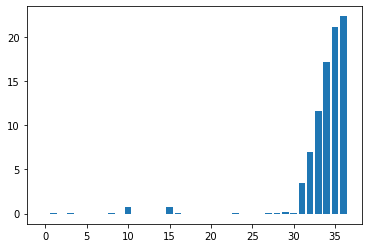

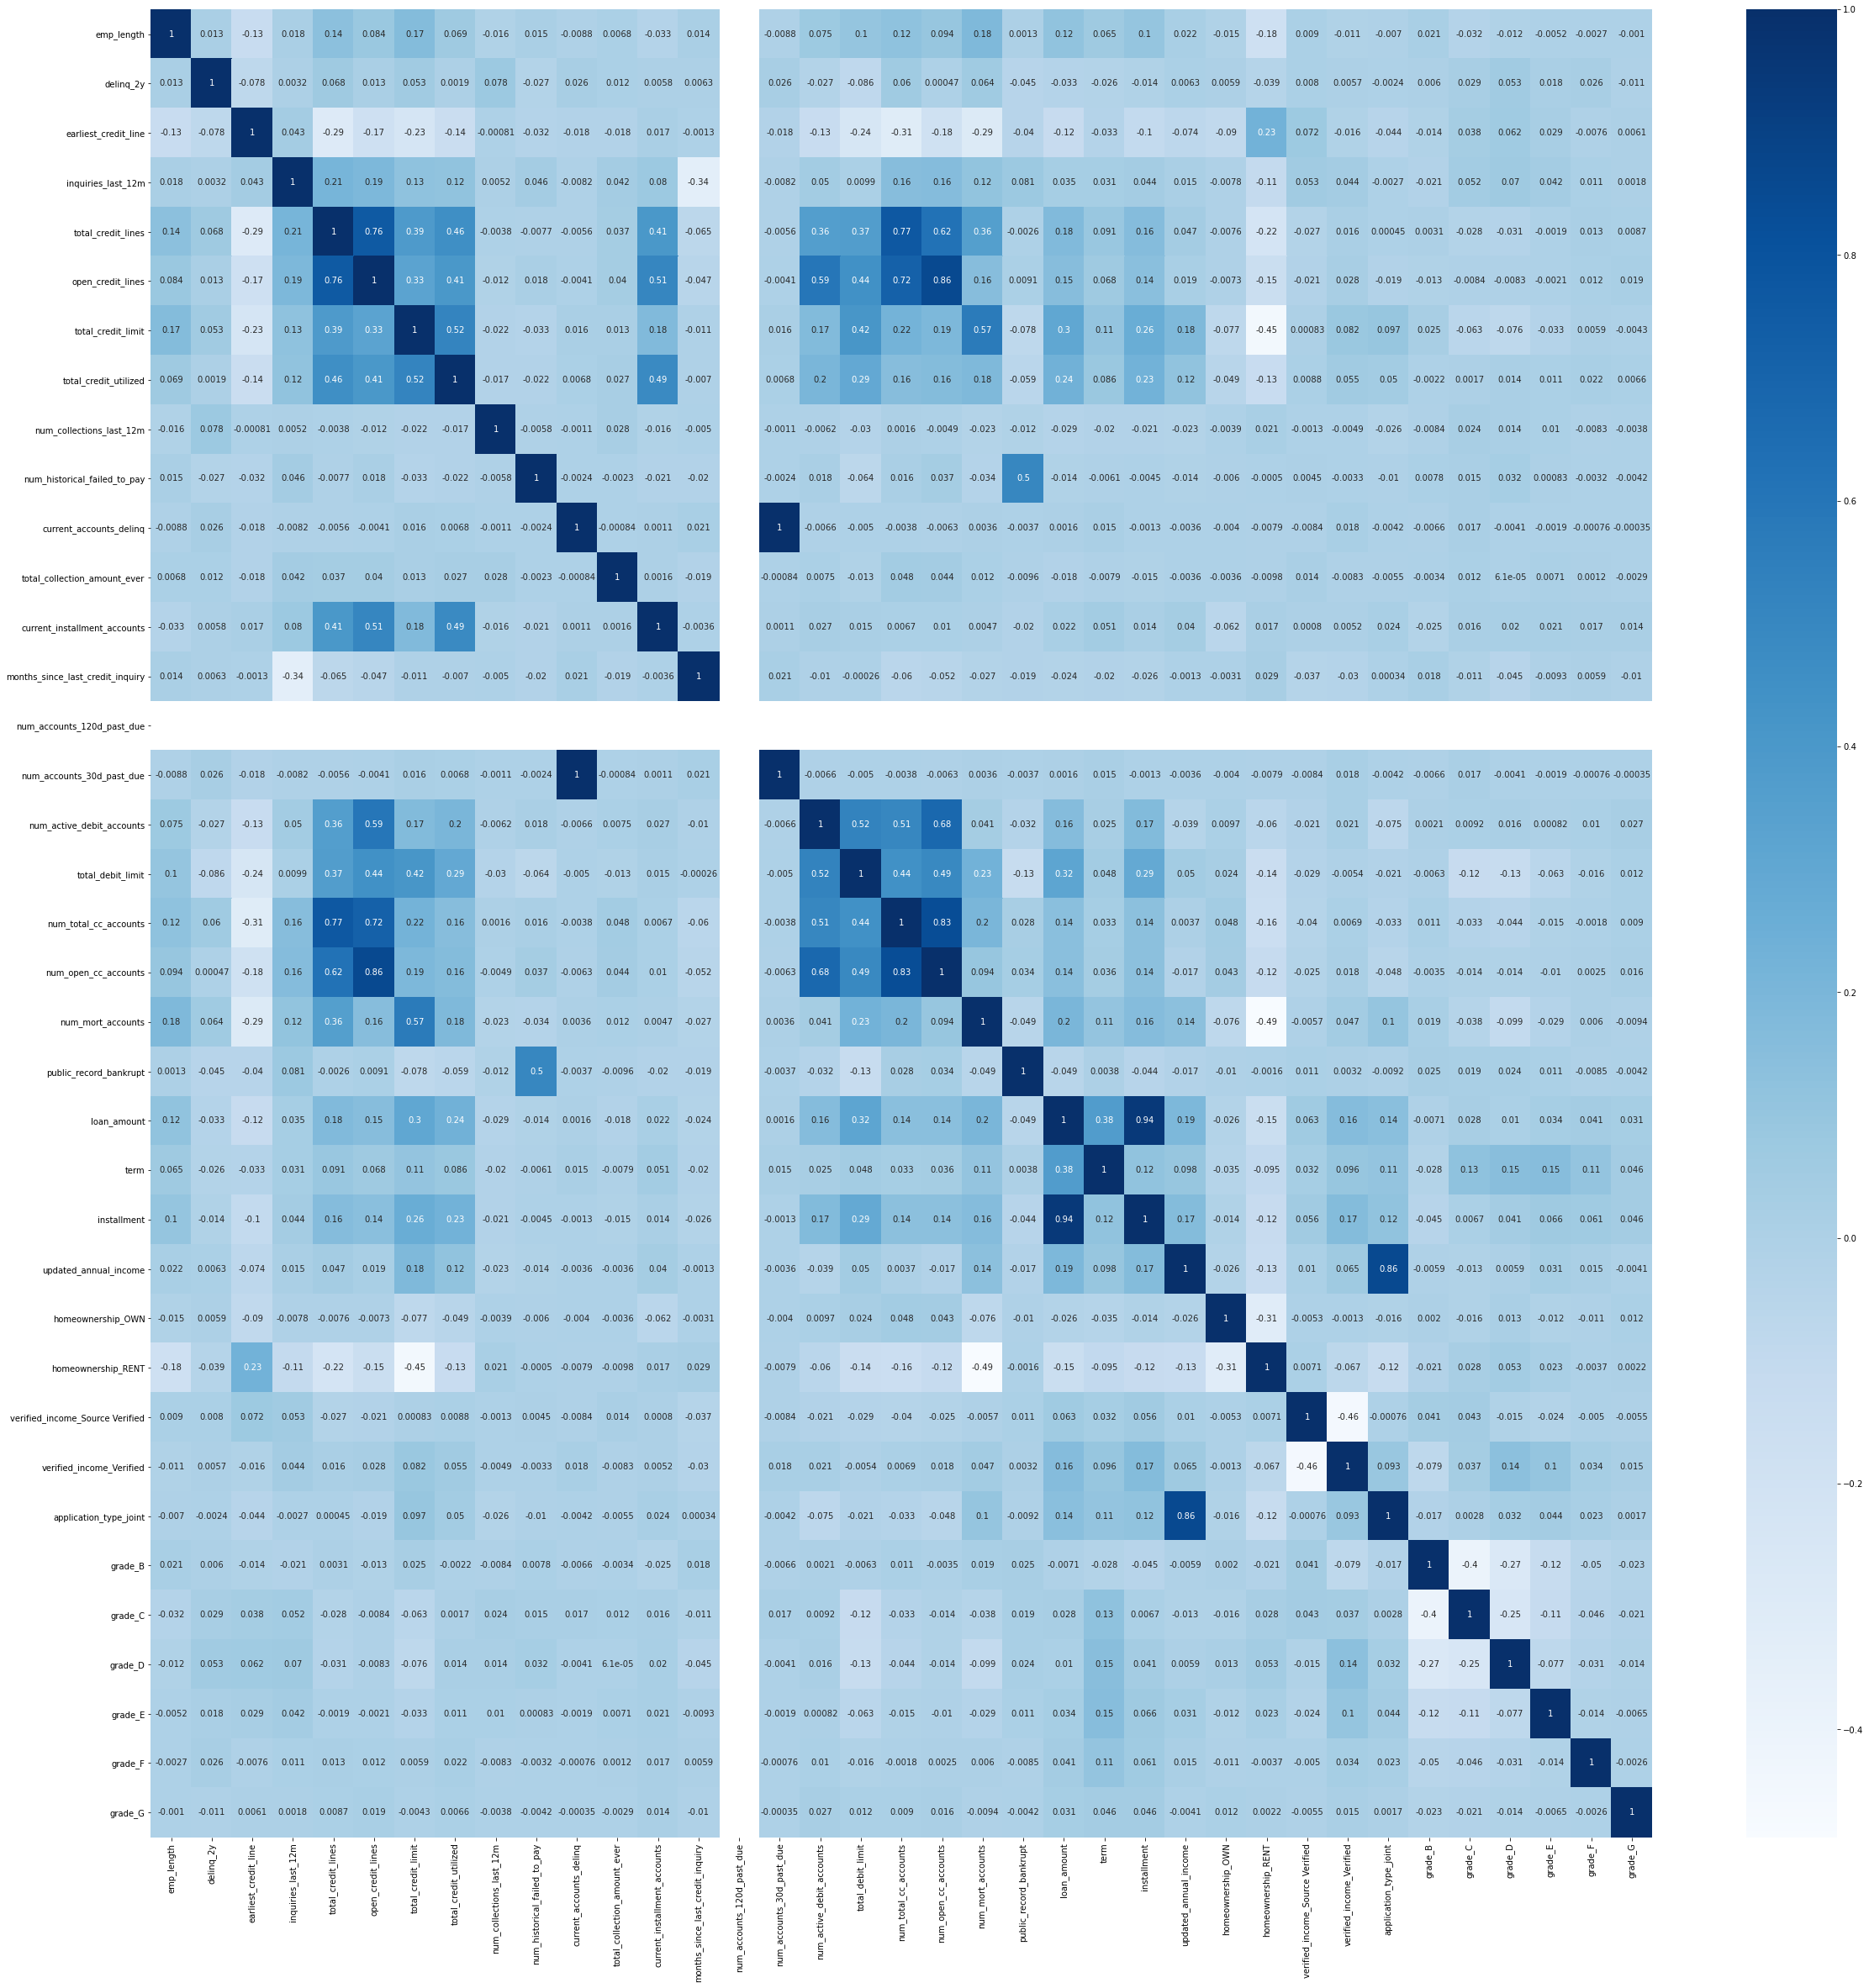

<Figure size 432x288 with 0 Axes>

In [242]:
model = LinearRegression()
model.fit(x,y)
importance = model.coef_

#x = sm.add_constant(x)
modelstat = sm.OLS(y, x).fit()
print(modelstat.summary())


for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

corr = x.corr(method='pearson')
corr.head()
plt.figure(figsize=(40,40))
sns.heatmap(corr,annot=True,cmap="Blues")
plt.figure()
plt.show()

Based on initial model results and assessing the P values of each features and correlation within the variables, following columns are dropped to improve the model.

In [243]:
df = df.drop(columns = ['open_credit_lines','num_active_debit_accounts','num_total_cc_accounts',
                                    'installment','num_active_debit_accounts','num_accounts_30d_past_due'])


In [244]:
df = df.astype({"emp_length":'int64', "months_since_last_credit_inquiry":'int64',"num_accounts_120d_past_due":'int64'
               ,"interest_rate":'int64',"updated_annual_income":'int64'})

In [245]:
df.dtypes

emp_length                          int64
delinq_2y                           int64
earliest_credit_line                int64
inquiries_last_12m                  int64
total_credit_lines                  int64
total_credit_limit                  int64
total_credit_utilized               int64
num_collections_last_12m            int64
num_historical_failed_to_pay        int64
current_accounts_delinq             int64
total_collection_amount_ever        int64
current_installment_accounts        int64
months_since_last_credit_inquiry    int64
num_accounts_120d_past_due          int64
total_debit_limit                   int64
num_open_cc_accounts                int64
num_mort_accounts                   int64
public_record_bankrupt              int64
loan_amount                         int64
term                                int64
interest_rate                       int64
updated_annual_income               int64
homeownership_OWN                   uint8
homeownership_RENT                

In [246]:
y=df['interest_rate']
x=df.drop(columns=["interest_rate"])

In [275]:
x.dtypes

emp_length                          int64
delinq_2y                           int64
earliest_credit_line                int64
inquiries_last_12m                  int64
total_credit_lines                  int64
total_credit_limit                  int64
total_credit_utilized               int64
num_collections_last_12m            int64
num_historical_failed_to_pay        int64
current_accounts_delinq             int64
total_collection_amount_ever        int64
current_installment_accounts        int64
months_since_last_credit_inquiry    int64
num_accounts_120d_past_due          int64
total_debit_limit                   int64
num_open_cc_accounts                int64
num_mort_accounts                   int64
public_record_bankrupt              int64
loan_amount                         int64
term                                int64
updated_annual_income               int64
homeownership_OWN                   uint8
homeownership_RENT                  uint8
verified_income_Source Verified   

                                 OLS Regression Results                                
Dep. Variable:          interest_rate   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          4.475e+04
Date:                Sat, 09 Jul 2022   Prob (F-statistic):                        0.00
Time:                        01:17:34   Log-Likelihood:                         -15099.
No. Observations:               10000   AIC:                                  3.026e+04
Df Residuals:                    9969   BIC:                                  3.048e+04
Df Model:                          31                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

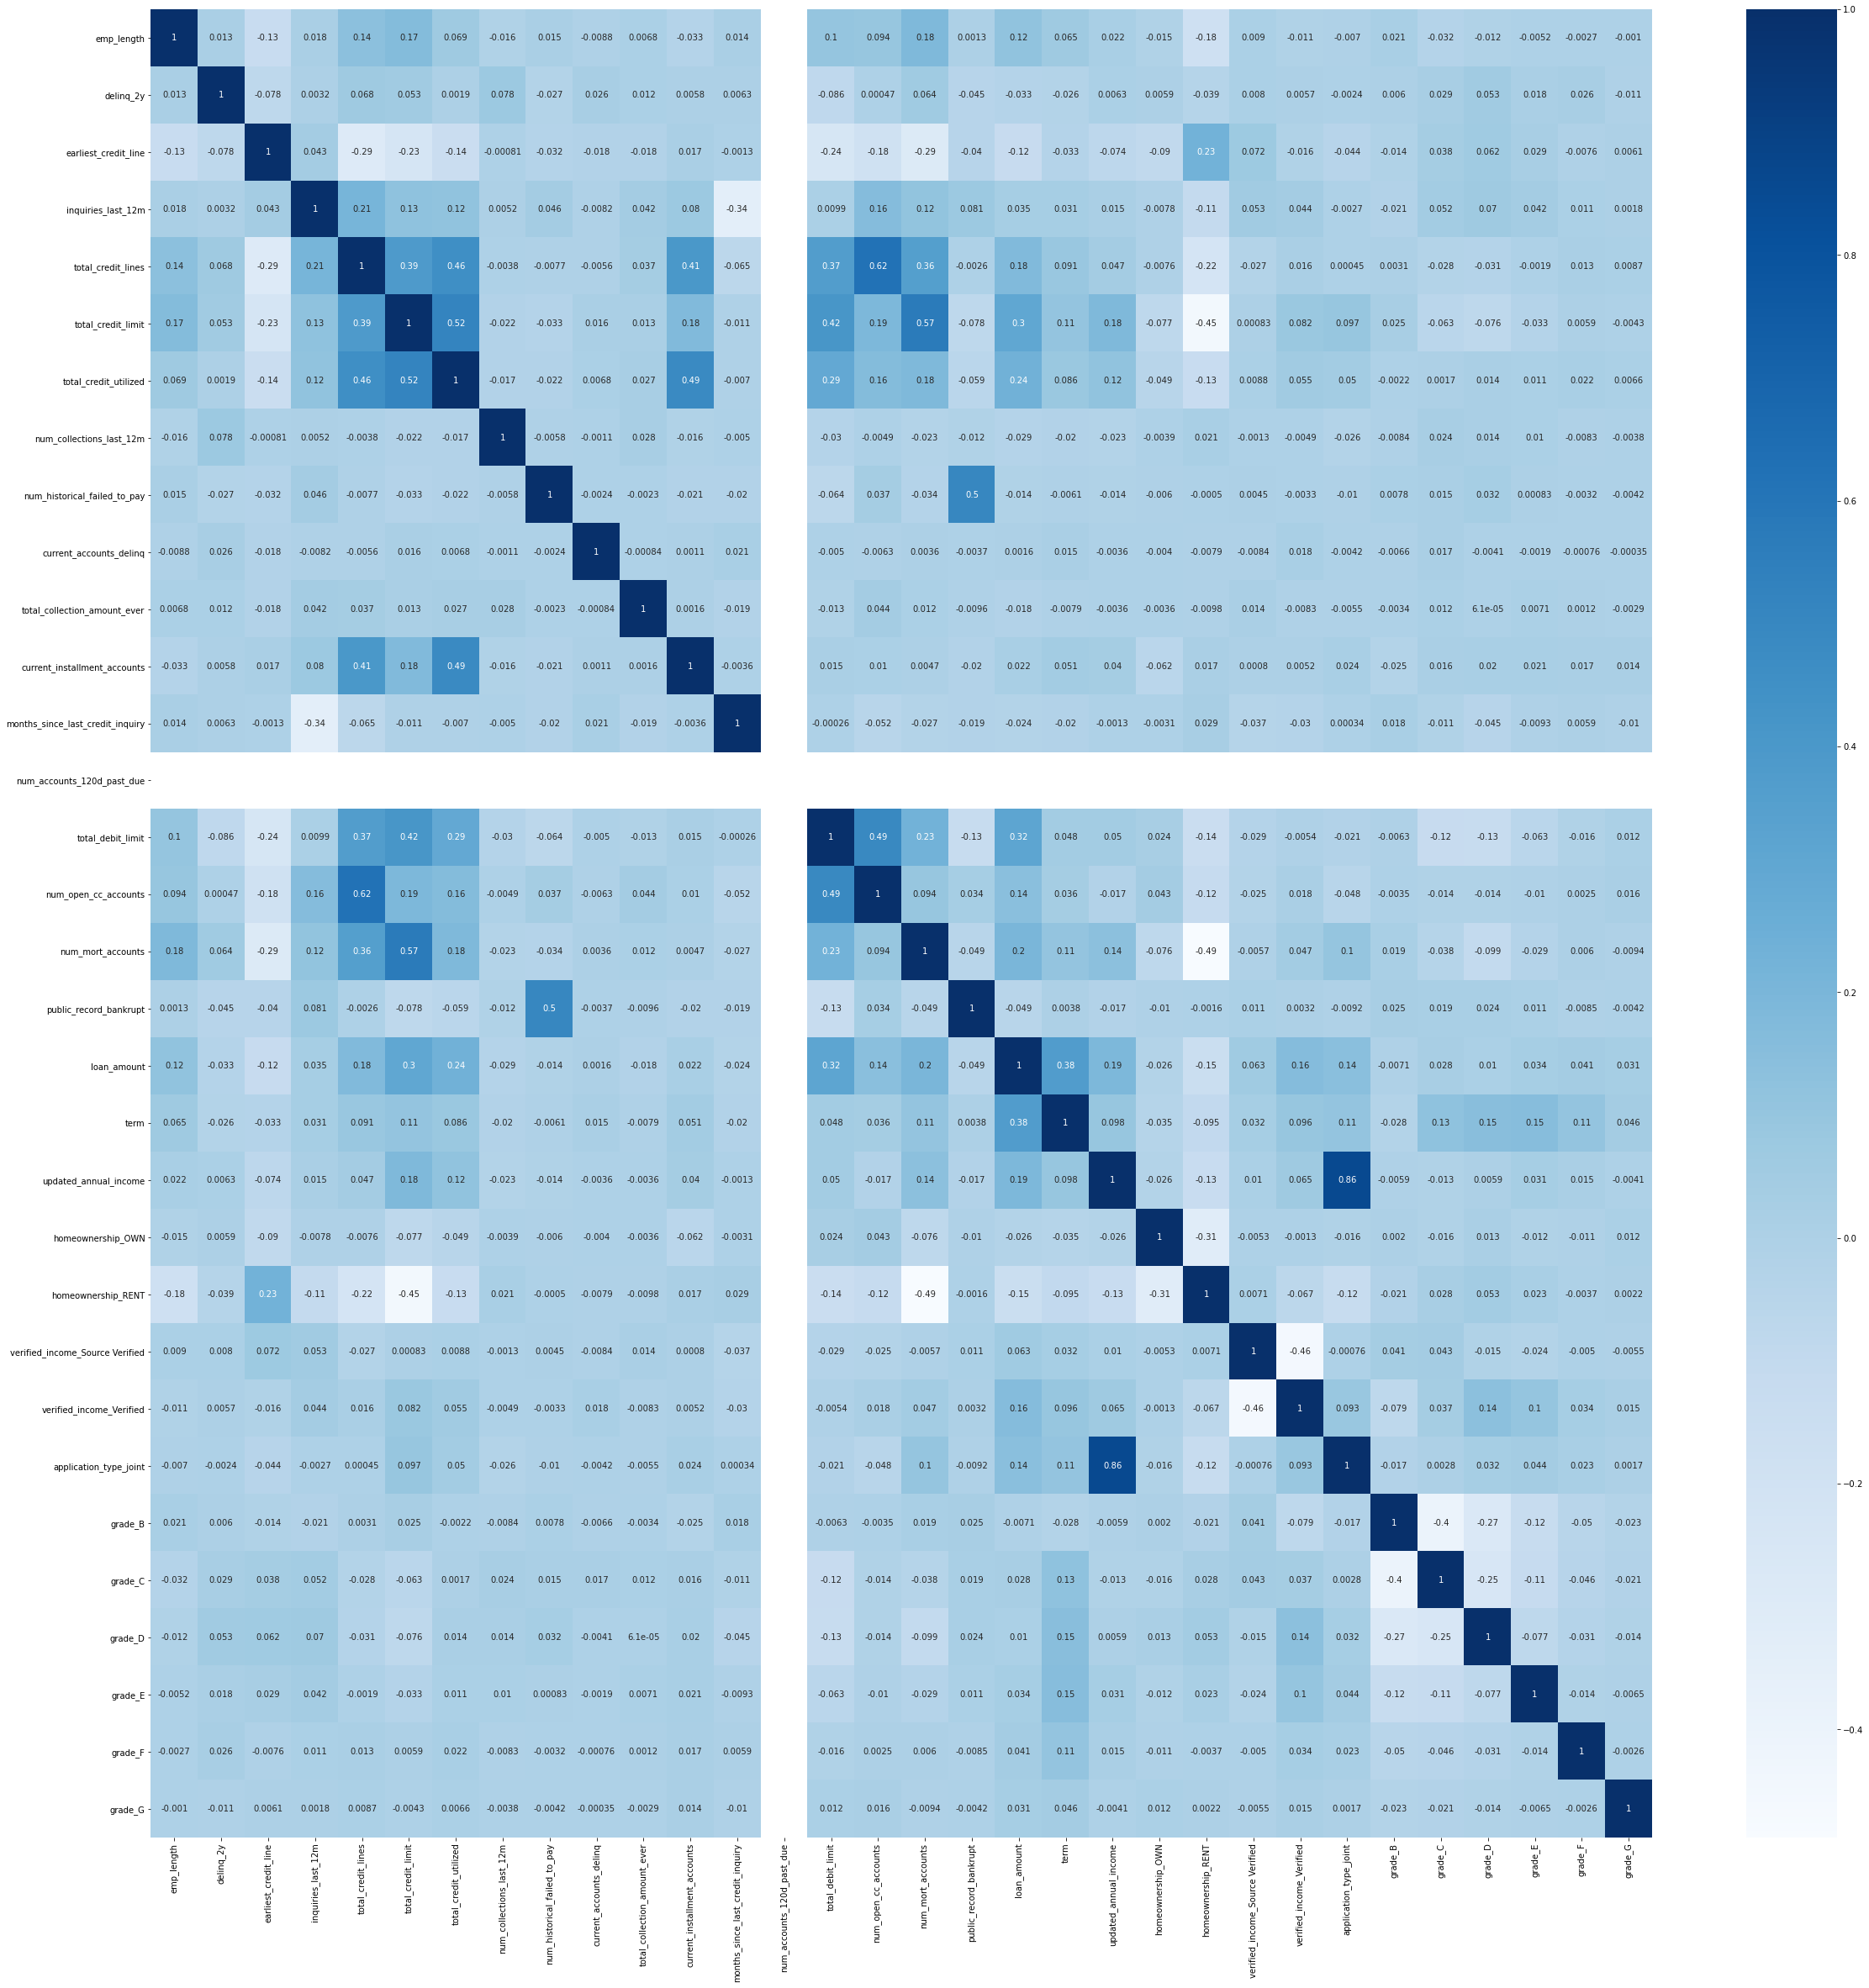

<Figure size 432x288 with 0 Axes>

In [342]:
model = LinearRegression()
model.fit(x,y)
importance = model.coef_

modelstat = sm.OLS(y, x).fit()
print(modelstat.summary())


corr = x.corr(method='pearson')
corr.head()
plt.figure(figsize=(40,40))
sns.heatmap(corr,annot=True,cmap="Blues")
plt.figure()
plt.show()

In [280]:
'''bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit_transform(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(25,'Score')) '''

"bestfeatures = SelectKBest(score_func=chi2, k=20)\nfit = bestfeatures.fit_transform(x,y)\ndfscores = pd.DataFrame(fit.scores_)\ndfcolumns = pd.DataFrame(x.columns)\nfeatureScores = pd.concat([dfcolumns,dfscores],axis=1)\nfeatureScores.columns = ['Specs','Score']  \nprint(featureScores.nlargest(25,'Score')) "

[4.59078007e-02 2.05813970e-02 5.48258444e-02 4.52433680e-02
 5.50663997e-02 5.61033147e-02 5.53263908e-02 3.36368777e-03
 1.27246504e-02 3.33434561e-05 2.34600256e-02 4.85152767e-02
 5.18795991e-02 0.00000000e+00 5.99079082e-02 5.28242129e-02
 3.59706733e-02 1.01701059e-02 5.56533177e-02 1.58277421e-02
 1.35901880e-02 1.17213556e-02 1.17680254e-02 1.42250339e-02
 9.82087684e-03 9.45736377e-03 1.01272182e-01 6.63938217e-02
 4.16198477e-02 1.23461607e-02 3.17705860e-03 1.22302744e-03]


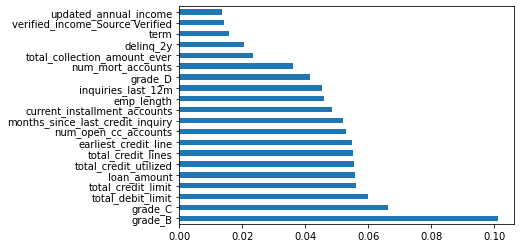

In [249]:
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Splitting data to test and train (feature selection based on collinearity)

In [268]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.3,stratify=y)

# Linear Regression 

In [269]:
model1 = LinearRegression()
model1.fit(x_train,y_train)

LinearRegression()

In [281]:
list(x.columns)

Index(['emp_length', 'delinq_2y', 'earliest_credit_line', 'inquiries_last_12m',
       'total_credit_lines', 'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m', 'num_historical_failed_to_pay',
       'current_accounts_delinq', 'total_collection_amount_ever',
       'current_installment_accounts', 'months_since_last_credit_inquiry',
       'num_accounts_120d_past_due', 'total_debit_limit',
       'num_open_cc_accounts', 'num_mort_accounts', 'public_record_bankrupt',
       'loan_amount', 'term', 'updated_annual_income', 'homeownership_OWN',
       'homeownership_RENT', 'verified_income_Source Verified',
       'verified_income_Verified', 'application_type_joint', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'],
      dtype='object')

In [270]:
y_pred = model1.predict(x_test)
mean_error = mean_absolute_error(y_test,y_pred)
mean_sqrd_error = mean_squared_error(y_test,y_pred)
print('Model error: ',mean_error)
print('RMSE: ',math.sqrt(mean_sqrd_error))


modelstat = sm.OLS(y_train, x_train).fit()
print(modelstat.summary())

Model error:  0.898966638185816
RMSE:  1.1356636711842085
                                 OLS Regression Results                                
Dep. Variable:          interest_rate   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          3.330e+04
Date:                Sat, 09 Jul 2022   Prob (F-statistic):                        0.00
Time:                        00:19:53   Log-Likelihood:                         -10467.
No. Observations:                7000   AIC:                                  2.099e+04
Df Residuals:                    6970   BIC:                                  2.120e+04
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                                       coef    std err        

# Running Linear Regression after feature selection based on previous models

In [325]:


'''new_X = x[['grade_E','grade_F','grade_D','grade_C','grade_B','total_credit_limit','total_debit_limit','paid_interest',
            'annual_income','total_credit_utilized','balance','loan_amount','paid_total','total_collection_amount_ever',
                       'months_since_90d_late','term','months_since_last_delinq','debt_to_income','inquiries_last_12m','paid_late_fees',
                       'accounts_opened_24m','disbursement_method_DirectPay','num_mort_accounts',
                         'verified_income_Verified']]'''

new_x = x[['earliest_credit_line', 'inquiries_last_12m',
       'total_credit_utilized',
       'current_accounts_delinq',
       'num_accounts_120d_past_due', 'total_debit_limit',
       'num_open_cc_accounts', 'num_mort_accounts',
       'loan_amount', 'updated_annual_income', 'application_type_joint', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']]


In [326]:
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(new_x, y, test_size=0.3, random_state=42)

In [327]:
model2 = LinearRegression()
model2.fit(x_train_n,y_train_n)
y_pred_new = model2.predict(x_test_n)
mean_error = mean_absolute_error(y_test_n,y_pred_new)
mean_sqrd_error = mean_squared_error(y_test_n,y_pred_new)


print('Regression model error: ',mean_error)
print('RMSE: ',math.sqrt(mean_sqrd_error))


Regression model error:  0.8994252226707795
RMSE:  1.0954369190257347


# XGBoost regressor 

In [328]:
model3 =XGBRegressor()
cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=1)
scores = cross_val_score(model3, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)

print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.924 (0.033)


In [329]:
model3.fit(x_train_n, y_train_n)
y_pred_3 = model3.predict(x_test_n)
mean_error = mean_absolute_error(y_test_n,y_pred_3)
mean_sqrd_error = mean_squared_error(y_test_n,y_pred_3)

print('Model error: ',mean_error)
print('RMSE: ',math.sqrt(mean_sqrd_error))

Model error:  0.9275490598678588
RMSE:  1.1457201865907045


### Conclusion and Future Enhancements

Linear regression model after feature selection performed better with mean absolute error of 0.899. 

Assumptions: 
Did not treat Na values as zeroes and removed entire columns like debt to income joint feature to build models.
Combined both income of individual and joint type to one single column and ran the model

The model can be further improved by implementing feature engineering like normalization of the key variables to better predict the interest rate. Moreover, Other regression models like Randomforest Regressor and by tuning the parameters, a better model can be built with improved accuracy. Poor data quality is one challenge that had to be dealt with and by fetching more reliable data with less Na values, we can see an improved model performance.

With my limited knowledge of the factors that affects the interest rate, the features were selected and models were trained. Upon more research and understanding the key factors, Important features can be chosen to build models and improve accuracy.
